# Decision trees v5.0
Kamil Kałużny 148121 <br>
Olga Gerlich 148088 <br>
Group L1
 <br>

In [1]:
import pandas as pd
import numpy as np
from graphviz import Source, Digraph
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('titanic-homework.csv')
df.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22,1,0,0


In [3]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Survived']
df = df[features]

### Categorical features

In [4]:
for column in df.columns:
    if column != 'Age':
        df[column] = df[column].astype('category')
        print(f'Column: {column}; No. of classes: {len(df[column].unique())} ---> {df[column].unique().to_list()}')

Column: Pclass; No. of classes: 3 ---> [3, 1, 2]
Column: Sex; No. of classes: 2 ---> ['male', 'female']
Column: SibSp; No. of classes: 6 ---> [1, 0, 3, 4, 2, 5]
Column: Parch; No. of classes: 5 ---> [0, 1, 2, 5, 3]
Column: Survived; No. of classes: 2 ---> [0, 1]


### Entropy
$H(S) = - \sum\limits_{y \in S}p(y)log_2p(y)$ <br> <br>
$U=|S|$

In [5]:
def entropy(X, S):
    U, H = len(X), 0
    for Ui in X[S].value_counts():
        p = Ui / U
        if p > 0:
            H += (-p * np.log2(p))
    return H

### Conditional entropy

$H(S|A) = - \sum\limits_{x \in A, y \in S} p(x,y) log_2 \frac{p(x,y)}{p(x)}$

Function <code> find_best_split(X,S,A) </code> calculates the best conditional entropy (the lowest) for a numerical attributes by iteratively evaluating each possible data split. <br>
Since it is more convenient in this function we used slightly different formula: <br>
$H(S|A) = \sum\limits_{j=1}^{m} \frac{|S_j|}{|S|} H(S_j)$

In [6]:
def find_best_split(X, S, A):
    U = len(X)
    best_entropy = np.inf
    split_value = 0
    for val in X[A].unique():
        split_condition = X[A] < val
        X1, X2 = X[split_condition], X[~split_condition]
        if len(X1) > 0 and len(X2) > 0:
            cur_entropy = len(X1) / U * entropy(X1, S) + len(X2) / U * entropy(X2, S)
            if cur_entropy < best_entropy:
                best_entropy = cur_entropy
                split_value = val
    return best_entropy, split_value

As mentioned above for non categorical attributes conditional entropy is calculated by find_best_split function.

In [7]:
def conditional_entropy(X, S, A):
    if X[A].dtype != 'category':
        H, _ = find_best_split(X, S, A)
        return H
    
    U, H = len(X), 0
    for Ai in X[A].unique():
        px = len(X[X[A] == Ai]) / U
        if px <= 0: continue

        for Si in X[S].unique():
            pxy = len(X[(X[A] == Ai) & (X[S] == Si)]) / U
            if pxy > 0:
                H += (-pxy * np.log2(pxy/px))
    return H

### Information gain
$IG(S,A) = H(S) - H(S|A)$

In [8]:
def information_gain(X, S, A):
    IG = entropy(X, S) - conditional_entropy(X, S, A)
    return IG

### Intrinsic information
$II(S,A)=- \sum\limits_{y \in S}\frac{|S_i|}{|S|}log_2p(\frac{|S_i|}{|S|})$

Formula is very similar as one for entropy but it focuses on distribution of values in leaves given split by $A$ attribute. <br>

For non categorical attributes intrinsic info needs to be calculated based on exact split condition, therefore find_best_split method is also used here.

In [9]:
def intrinsic_info(X, S, A):
    U, info = len(X), 0
    if X[A].dtype != 'category':
        _, split_value = find_best_split(X, S, A)
        split_condition = X[A] < split_value
        X1, X2 = X[split_condition], X[~split_condition]
        p1, p2 = len(X1) / U, len(X2) / U
        info = - p1 * np.log2(p1) - p2 * np.log2(p2)  
        return info
    
    for Ui in X[A].value_counts():
        p = Ui / U
        if p > 0:
            info += (-p * np.log2(p))
    return info

### Gain ratio
$IGR(S,A) = \frac{IG(S,A)}{II(S,A)}$

In [10]:
def gain_ratio(X, S, A):
    IGR = information_gain(X, S, A) / intrinsic_info(X, S, A)
    return IGR

### ID3

#### Pseudocode
<code>ID3 (Examples, Target_Attribute, Attributes)
    Create a root node for the tree
    If all examples are positive, Return the single-node tree Root, with label = +.
    If all examples are negative, Return the single-node tree Root, with label = -.
    If number of predicting attributes is empty, then Return the single node tree Root,
    with label = most common value of the target attribute in the examples.
    Otherwise Begin
        A ← The Attribute that best classifies examples.
        Decision Tree attribute for Root = A.
        For each possible value, vi, of A,
            Add a new tree branch below Root, corresponding to the test A = vi.
            Let Examples(vi) be the subset of examples that have the value vi for A
            If Examples(vi) is empty
                Then below this new branch add a leaf node with label = most common target value in the examples
            Else below this new branch add the subtree ID3 (Examples(vi), Target_Attribute, Attributes – {A})
    End
    Return Root</code> <br>

[Source](https://en.wikipedia.org/wiki/ID3_algorithm) <br> <br>

<code>A ← The Attribute that best classifies examples. </code> <br>
The best attribute is chosen as the one with the highest gain ratio. Gain ratio itself is normalized version of information gain which is a metric that is commonly used in decision trees in order to estimate the best possible condition split in particular node. It is calculated using entropy, conditional entropy and intrinsic info - all of formulas are provided above the functions that they are corresponding to. <br> <br>

Field <code>split_value</code> was added to monitor whether a node is associated with numerical attribute and to display split condition tree's edges.

In [11]:
class Node:
    def __init__(self, attr=None, label=None, split_value=None):
        self.attr = attr
        self.label = label
        self.child = {}
        self.count = 0
        self.split_value = split_value
    
    def visualize(self, dot=None):
        if dot is None:
            dot = Digraph()
        
        if self.label is not None:
            leaf_label = f"{self.label} [{self.count}]"
        else:
            leaf_label = str(self.attr)
        
        node_id = str(id(self))
        dot.node(name=node_id, label=leaf_label)
        
        for value, child_node in self.child.items():
            child_id = str(id(child_node))
            dot.edge(node_id, child_id, label=str(value))
            child_node.visualize(dot)

        return dot
    
    def update_leaf_count(self, data):
        for i in range(len(data)):
            sample = data.iloc[i]
            node = self
            
            while True:
                attr = node.attr
                split_value = node.split_value
                if split_value is not None:
                    if sample[attr] < split_value:
                        node = node.child[f'<{split_value}']
                    else:
                        node = node.child[f'>={split_value}']
                else:
                    if node.attr is None:
                        node.count += 1
                        break
                    decision = sample[attr]
                    node = node.child[decision]
                    

In [12]:
def id3(X, y, attr, depth=0):
    if len(np.unique(y)) <= 1:
        return Node(label=y.iloc[0])

    if X.empty or len(attr) == 0:
        return Node(label=y.value_counts().idxmax())

    gain_ratios = np.array([gain_ratio(X, target, a) for a in attr])
    i = np.argmax(gain_ratios)
    A, best_ratio = attr[i], gain_ratios[i]
    
    split_value = None
    if X[A].dtype != 'category':
        _, split_value = find_best_split(X, target, A)
    
    root = Node(attr=A, split_value=split_value)
    attr = attr.drop(A)
    
    if X[A].dtype != 'category':
        split_condition = X[A] < split_value
        X1, X2 = X[split_condition], X[~split_condition]
        y1, y2 = y[split_condition], y[~split_condition]
        root.child[f'<{split_value}'] = id3(X1, y1, attr, depth + 1)
        root.child[f'>={split_value}'] = id3(X2, y2, attr, depth + 1)

    else:
        for vi in X[A].unique():
            X_copy = X[X[A] == vi]
            y_copy = y[X[A] == vi]
            root.child[vi] = id3(X_copy, y_copy, attr, depth + 1)
        
    return root

target = 'Survived'
attributes = df.drop(columns=(target)).columns
root = id3(df, df[target], attributes)
root.update_leaf_count(df)

/tmp/ipykernel_38994/2448395234.py:2: RuntimeWarning: invalid value encountered in scalar divide
  IGR = information_gain(X, S, A) / intrinsic_info(X, S, A)


### Decision tree visualization

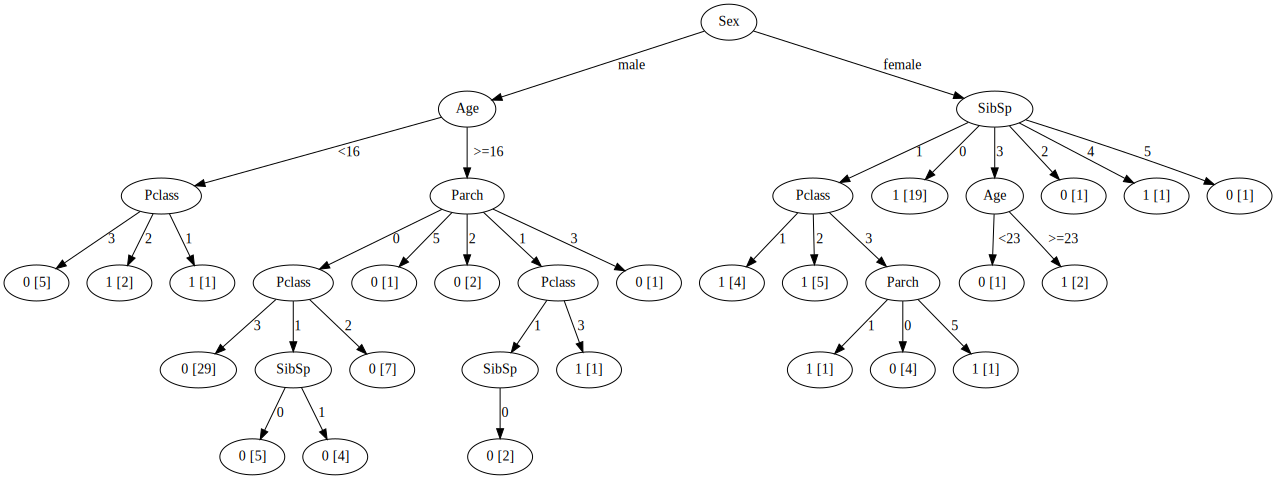

In [13]:
graph = root.visualize()
graph.render("decision_tree5", view=False)
Source.from_file("decision_tree5")

Values in square brackets represent the samples that have been classified by following the path that leads to that specific leaf node.